In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *

print(os.getpid())

3044


In [2]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'human_NRNX1_5kb')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
else:
    print(f"Use library_folder: {library_folder}")

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain
Use library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_NRNX1_5kb


## 3.1 design readout mapping dict (region_to_readout)

idea for this library:

> 1. each gene has 3 on-bits from 20 total-bits

> 2. split this entire region into 20 sets:

>> 2.1 first 10 sets are for first half of regions

In [3]:
from ImageAnalysis3.library_tools import encoding

In [4]:
on_num = 3
total_num = 24

encoding_file = os.path.join(library_folder, f'covering_v_{total_num}_k_{on_num}_t_2.txt')
loaded_bits = []

with open(encoding_file, 'r') as _handle:
    # start reading
    _lines = _handle.read().split('\n')
    for _line in _lines:
        _bits = [int(_i)-1 for _i in _line.split(' ') if len(_i) > 0]
        loaded_bits.append(_bits)

loaded_bits = np.array(loaded_bits, dtype=np.int32)
print(np.shape(loaded_bits))

# remove redundant bits
kept_bits = loaded_bits.copy()
kept_inds = np.zeros(len(kept_bits))
while np.sum(kept_inds) != len(kept_inds):
    kept_inds = np.ones(len(kept_bits), dtype=bool)
    _kept_mat = encoding.convert_bits_to_matrix(kept_bits)
    _dists = (total_num - (_kept_mat @ _kept_mat.T)) / 2
    _x, _y = np.where((_dists > 0) * (_dists <= 3))
    if len(_x) > 0:
        kept_inds[_x[0]] = False
        kept_bits = kept_bits[kept_inds]
        print(np.sum(kept_inds), kept_inds[_x[0]])
print(kept_bits.shape)

(96, 3)
95 False
94 False
93 False
92 False
91 False
90 False
89 False
88 False
87 False
86 False
85 False
84 False
(84, 3)


In [6]:
encoding_bits = kept_bits.copy()
encoding_mat = encoding.convert_bits_to_matrix(encoding_bits)

In [7]:
encoding_folder = os.path.join(library_folder, 'Encoding_design')
if not os.path.exists(encoding_folder):
    os.makedirs(encoding_folder)
    print(encoding_folder)

pickle.dump(encoding_bits, open(os.path.join(encoding_folder, f'encoding_bits_total-{total_num}_on-{on_num}'), 'wb'))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_NRNX1_5kb\Encoding_design


In [3]:
chr_2_region_num = pickle.load( open(os.path.join(library_folder, 'chr_2_final_region_num.pkl'), 'rb'))
chr_2_region_num

{'2': 668}

In [4]:
# 1. split this region into half
region_num = chr_2_region_num['2']
print(region_num)
half_group_num = 10
print(half_group_num)
group_rids = [np.arange(_i, region_num, half_group_num) for _i in range(half_group_num)]


668
10


In [14]:
# 2. optimize order within each set
np.random.seed(0)
gsize_2_codes = {}
gsize_2_bit_usage = {}
for _size in np.unique([len(_g) for _g in group_rids]):
    print(f"group size: {_size}")
    # init candidate codes
    cand_codes = list(encoding_bits.copy())
    # init gsize_2_codes as final output
    gsize_2_codes[_size] = []
    # try to assign as even as possible for this group
    _group_bit_usage = np.zeros(np.max(cand_codes) + 1)
    
    while len(gsize_2_codes[_size]) < _size:
        # for each cand_code, estimate overlap
        _cand_code_bit_usage = [np.sum(_group_bit_usage[_code]**2) for _code in cand_codes]
        # find the least overlapping candidate
        _least_overlap_inds = []
        _usage_th = np.min(_cand_code_bit_usage)
        while len(_least_overlap_inds) == 0:
            _least_overlap_inds = np.where(np.array(_cand_code_bit_usage)<=_usage_th)[0]
            _usage_th += 1
        # randomly select one among the least overlapping codes
        _rand_least_overlap_ind = _least_overlap_inds[np.random.randint(len(_least_overlap_inds))]
        # remove this code from cand_bit pool
        _sel_cand = cand_codes.pop(_rand_least_overlap_ind)
        # update final list
        gsize_2_codes[_size].append(_sel_cand)
        # update local group bit usage
        _group_bit_usage[_sel_cand] += 1
        print(f"{np.max(_group_bit_usage)}, {_sel_cand}")
    # save bit_usage
    gsize_2_bit_usage[_size] = _group_bit_usage

group size: 66
1.0, [ 6 11 12]
1.0, [ 0 13 19]
1.0, [1 2 4]
1.0, [ 3 17 21]
1.0, [ 8 20 23]
1.0, [10 14 15]
2.0, [ 5  9 17]
2.0, [ 7 18 20]
2.0, [ 0 16 22]
2.0, [ 7 19 21]
2.0, [ 6 10 23]
2.0, [ 3  4 16]
2.0, [ 1 13 22]
2.0, [ 2  8 12]
3.0, [14 18 22]
3.0, [ 9 11 20]
3.0, [ 4  5 15]
3.0, [1 5 7]
3.0, [ 3  8 14]
3.0, [ 9 12 13]
3.0, [18 19 23]
3.0, [ 0 11 15]
3.0, [10 16 17]
4.0, [ 2  6 13]
4.0, [ 2 20 21]
4.0, [15 16 23]
4.0, [6 8 9]
4.0, [ 7 11 17]
4.0, [ 4 10 18]
4.0, [0 1 3]
5.0, [ 5 14 16]
5.0, [10 12 19]
5.0, [21 22 23]
5.0, [ 2  9 15]
5.0, [11 13 18]
5.0, [ 1 14 20]
5.0, [ 4 17 19]
5.0, [ 3  7 12]
6.0, [ 5  6 19]
6.0, [ 0 12 21]
6.0, [ 7  8 22]
6.0, [13 16 20]
6.0, [ 0 14 17]
6.0, [ 2 10 22]
6.0, [ 1 11 21]
6.0, [ 3  9 18]
7.0, [ 4 11 23]
7.0, [ 8 15 19]
7.0, [ 5 10 13]
7.0, [0 4 6]
7.0, [ 6 16 18]
7.0, [ 9 14 23]
7.0, [12 17 22]
7.0, [ 3 15 20]
8.0, [ 8 16 21]
8.0, [ 2  7 14]
8.0, [ 5 11 22]
8.0, [ 1 17 23]
8.0, [ 9 10 21]
8.0, [ 1 15 18]
8.0, [ 2  3 19]
8.0, [ 4 12 20]
9.0, [0 

In [15]:
reload(ia.library_tools.encoding)

<module 'ImageAnalysis3.library_tools.encoding' from 'E:\\Users\\puzheng_new\\Documents\\Chromatin_Analysis_Scripts\\Library_design\\CTP-14-human_brain_genome\\..\\..\\..\\..\\Documents\\ImageAnalysis3\\library_tools\\encoding.py'>

In [16]:
from tqdm import tqdm

In [18]:
sorted_gsize_2_codes = {}
sorted_gsize_2_dists = {}
for _size, _codes in gsize_2_codes.items():
    print(f"group size: {_size}")
    _code_degrees = np.array([np.sum(gsize_2_bit_usage[_size][_code]) for _code in _codes])
    final_sorted_codes = []
    # try random sorting for many times
    final_dists = [0,0]
    for _iter in tqdm(range(2000)):
        # set random seed
        #np.random.seed(_iter*1001)
        _sorted_codes = []
        # select from small to large degreed codes
        for _degree in np.unique(_code_degrees):
            _cand_codes = [tuple(_c) for _c in np.array(_codes)[np.where(_code_degrees==_degree)[0]]]
            # shuffle candidate codes
            np.random.shuffle(_cand_codes)
            # within these candidate codes, insert to the best place
            for _code in _cand_codes:
                _dists = [encoding.calculate_closest_overlap(_sorted_codes, _code, _loc)
                          for _loc in range(0, len(_sorted_codes)+1)]
                # randomly select one of the smallest dist location insert:
                _sel_ind = np.random.choice(np.where(_dists == np.nanmax(_dists))[0])
                _sorted_codes.insert(_sel_ind, _code)
                #print(_dists, np.max(_dists), np.argmax(_dists))
        # given this order, check the internal distances
        _sorted_dists = []
        for _i, _code in enumerate(_sorted_codes):
            _other_codes = [_c for _j, _c in enumerate(_sorted_codes) if _i != _j]
            _sorted_dists.append(encoding.calculate_closest_overlap(_other_codes, _code, _i))
        if np.nanmin(_sorted_dists) > np.nanmin(final_dists) \
        or ( (np.nanmin(_sorted_dists) == np.nanmin(final_dists)) \
            and (np.nanmean(_sorted_dists) > np.nanmean(final_dists)) ):
            final_dists = np.array(_sorted_dists)
            final_codes = [np.array(_c) for _c in _sorted_codes]
            print(f'Change in iter: {_iter}, min_dist={int(np.nanmin(final_dists))},  mean_dist={np.nanmean(final_dists):.2f}')
    # save
    sorted_gsize_2_codes[_size] = final_codes
    sorted_gsize_2_dists[_size] = final_dists

group size: 66


  0%|                                                                                 | 1/2000 [00:00<07:26,  4.48it/s]

Change in iter: 0, min_dist=1,  mean_dist=4.56


  0%|                                                                                 | 2/2000 [00:00<07:25,  4.48it/s]

Change in iter: 1, min_dist=3,  mean_dist=4.77


  1%|▌                                                                               | 13/2000 [00:02<07:22,  4.49it/s]

Change in iter: 12, min_dist=3,  mean_dist=4.92


  1%|▉                                                                               | 23/2000 [00:05<07:20,  4.49it/s]

Change in iter: 22, min_dist=4,  mean_dist=4.86


 38%|█████████████████████████████▊                                                 | 754/2000 [02:46<04:34,  4.54it/s]

Change in iter: 753, min_dist=4,  mean_dist=4.89


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:23<00:00,  4.51it/s]


group size: 67


  0%|                                                                                 | 1/2000 [00:00<07:46,  4.29it/s]

Change in iter: 0, min_dist=3,  mean_dist=4.54


  0%|                                                                                 | 3/2000 [00:00<07:42,  4.32it/s]

Change in iter: 2, min_dist=3,  mean_dist=4.63


  1%|▍                                                                               | 12/2000 [00:02<07:35,  4.36it/s]

Change in iter: 11, min_dist=3,  mean_dist=4.75


  1%|▋                                                                               | 17/2000 [00:03<07:36,  4.34it/s]

Change in iter: 16, min_dist=3,  mean_dist=4.84


  2%|█▉                                                                              | 49/2000 [00:11<07:26,  4.37it/s]

Change in iter: 48, min_dist=3,  mean_dist=4.87


  4%|███                                                                             | 78/2000 [00:17<07:23,  4.33it/s]

Change in iter: 77, min_dist=4,  mean_dist=4.97


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:37<00:00,  4.37it/s]


## Assemble based on groups

loop through groups and assign bits

In [25]:
rid_2_code = {}
for _ig, _rids in enumerate(group_rids):
    _size = len(_rids)
    _group_codes = sorted_gsize_2_codes[_size]
    for _rid, _code in zip(_rids, _group_codes):
        _full_code = _code + _ig * total_num
        #print(_rid, _code, _full_code)
        rid_2_code[_rid] = _full_code
    #break
rid_2_code = {_k:rid_2_code[_k] for _k in sorted(rid_2_code)}

In [26]:
# calculate the final code gdists
total_codes = list(rid_2_code.values())
total_dists = []
for _i, _code in enumerate(total_codes):
    total_dists.append(
        encoding.calculate_closest_overlap([_c for _j, _c in enumerate(total_codes) if _i != _j], 
                                           _code, _i)
    )

In [27]:
np.where(np.array(total_codes)==7)

(array([ 20, 120, 210, 280, 340, 390, 540, 620], dtype=int64),
 array([1, 0, 0, 0, 1, 1, 0, 2], dtype=int64))

<IPython.core.display.Javascript object>


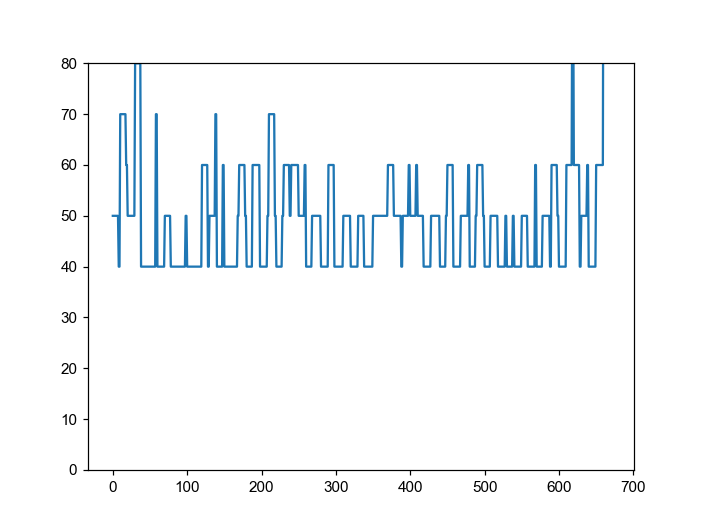

(0.0, 80.0)

In [28]:
plt.figure()
plt.plot(total_dists)
plt.ylim([0,80])

# region to bits

In [5]:
# load
chr_2_region_names = pickle.load(open(os.path.join(library_folder,'chr_2_region_names.pkl'), 'rb'))

In [6]:
chr_2_region_names

{'2': ['NRNX1-seg-1',
  'NRNX1-seg-2',
  'NRNX1-seg-3',
  'NRNX1-seg-4',
  'NRNX1-seg-5',
  'NRNX1-seg-6',
  'NRNX1-seg-7',
  'NRNX1-seg-9',
  'NRNX1-seg-10',
  'NRNX1-seg-13',
  'NRNX1-seg-14',
  'NRNX1-seg-15',
  'NRNX1-seg-16',
  'NRNX1-seg-17',
  'NRNX1-seg-18',
  'NRNX1-seg-19',
  'NRNX1-seg-20',
  'NRNX1-seg-21',
  'NRNX1-seg-22',
  'NRNX1-seg-23',
  'NRNX1-seg-24',
  'NRNX1-seg-25',
  'NRNX1-seg-26',
  'NRNX1-seg-27',
  'NRNX1-seg-28',
  'NRNX1-seg-30',
  'NRNX1-seg-31',
  'NRNX1-seg-32',
  'NRNX1-seg-33',
  'NRNX1-seg-34',
  'NRNX1-seg-35',
  'NRNX1-seg-36',
  'NRNX1-seg-37',
  'NRNX1-seg-38',
  'NRNX1-seg-39',
  'NRNX1-seg-40',
  'NRNX1-seg-41',
  'NRNX1-seg-42',
  'NRNX1-seg-43',
  'NRNX1-seg-44',
  'NRNX1-seg-45',
  'NRNX1-seg-46',
  'NRNX1-seg-47',
  'NRNX1-seg-48',
  'NRNX1-seg-49',
  'NRNX1-seg-50',
  'NRNX1-seg-51',
  'NRNX1-seg-52',
  'NRNX1-seg-53',
  'NRNX1-seg-54',
  'NRNX1-seg-55',
  'NRNX1-seg-56',
  'NRNX1-seg-57',
  'NRNX1-seg-58',
  'NRNX1-seg-59',
  'NRNX1-seg-

In [8]:
region_2_group_id = {}
for _group, _rids in enumerate(group_rids):
    for _rid in _rids:
        _region = chr_2_region_names['2'][_rid]
        region_2_group_id[_region] = _group
region_2_group_id = {_n:_g for _n, _g in sorted(region_2_group_id.items(), key=lambda v:int(v[0].split('seg-')[-1]))}

In [9]:
region_2_group_id

{'NRNX1-seg-1': 0,
 'NRNX1-seg-2': 1,
 'NRNX1-seg-3': 2,
 'NRNX1-seg-4': 3,
 'NRNX1-seg-5': 4,
 'NRNX1-seg-6': 5,
 'NRNX1-seg-7': 6,
 'NRNX1-seg-9': 7,
 'NRNX1-seg-10': 8,
 'NRNX1-seg-13': 9,
 'NRNX1-seg-14': 0,
 'NRNX1-seg-15': 1,
 'NRNX1-seg-16': 2,
 'NRNX1-seg-17': 3,
 'NRNX1-seg-18': 4,
 'NRNX1-seg-19': 5,
 'NRNX1-seg-20': 6,
 'NRNX1-seg-21': 7,
 'NRNX1-seg-22': 8,
 'NRNX1-seg-23': 9,
 'NRNX1-seg-24': 0,
 'NRNX1-seg-25': 1,
 'NRNX1-seg-26': 2,
 'NRNX1-seg-27': 3,
 'NRNX1-seg-28': 4,
 'NRNX1-seg-30': 5,
 'NRNX1-seg-31': 6,
 'NRNX1-seg-32': 7,
 'NRNX1-seg-33': 8,
 'NRNX1-seg-34': 9,
 'NRNX1-seg-35': 0,
 'NRNX1-seg-36': 1,
 'NRNX1-seg-37': 2,
 'NRNX1-seg-38': 3,
 'NRNX1-seg-39': 4,
 'NRNX1-seg-40': 5,
 'NRNX1-seg-41': 6,
 'NRNX1-seg-42': 7,
 'NRNX1-seg-43': 8,
 'NRNX1-seg-44': 9,
 'NRNX1-seg-45': 0,
 'NRNX1-seg-46': 1,
 'NRNX1-seg-47': 2,
 'NRNX1-seg-48': 3,
 'NRNX1-seg-49': 4,
 'NRNX1-seg-50': 5,
 'NRNX1-seg-51': 6,
 'NRNX1-seg-52': 7,
 'NRNX1-seg-53': 8,
 'NRNX1-seg-54': 9,
 'NRNX1-

In [10]:
# save
pickle.dump(region_2_group_id, open(os.path.join(library_folder, 'region_2_group_id.pkl'), 'wb'))

In [12]:
len(chr_2_region_names['2'])

668

In [32]:
# assemble to regionrate region_to_encoding_bits
region_2_bits = {}
for _rid, _rname in enumerate(chr_2_region_names['2']):
    region_2_bits[_rname] = rid_2_code[_rid]

In [33]:
print("saving")
pickle.dump(region_2_bits, open(os.path.join(encoding_folder, f'region_2_bits.pkl'), 'wb'))

saving


In [34]:
region_2_readout_dict = {}
for _iregion, _region in enumerate(region_2_bits):
    region_2_readout_dict[_region] = []#[f"u{_iregion}"]
    region_2_readout_dict[_region].extend([f"c{_b}" for _b in region_2_bits[_region]])

# save
pickle.dump(region_2_readout_dict, open(os.path.join(library_folder, 'region_2_readout.pkl'), 'wb'))